# 📈 Cryptocurrency Price Prediction using Machine Learning
This notebook demonstrates a cryptocurrency price prediction pipeline using historical data and simulated sentiment analysis.

We'll simulate price and news data for Bitcoin and Ethereum, perform EDA, apply sentiment analysis, and build a simple Linear Regression model to predict 2025 prices.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nsmokey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


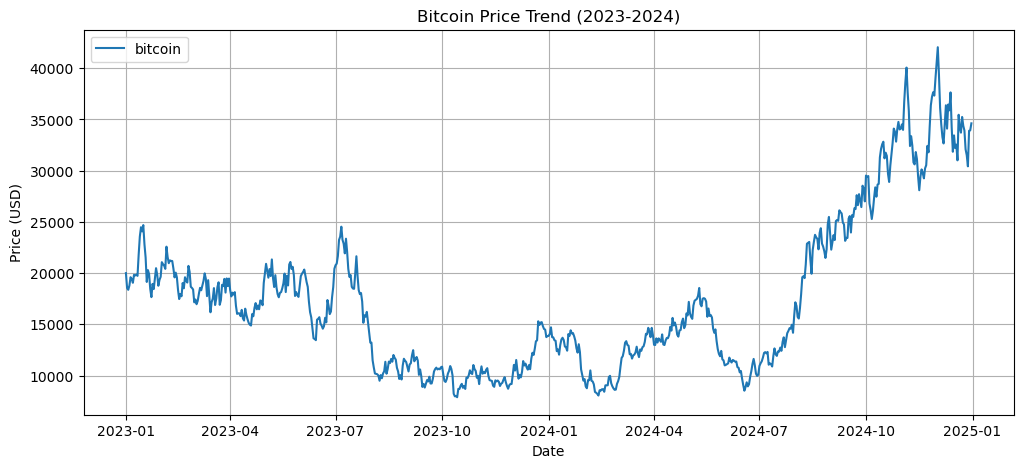

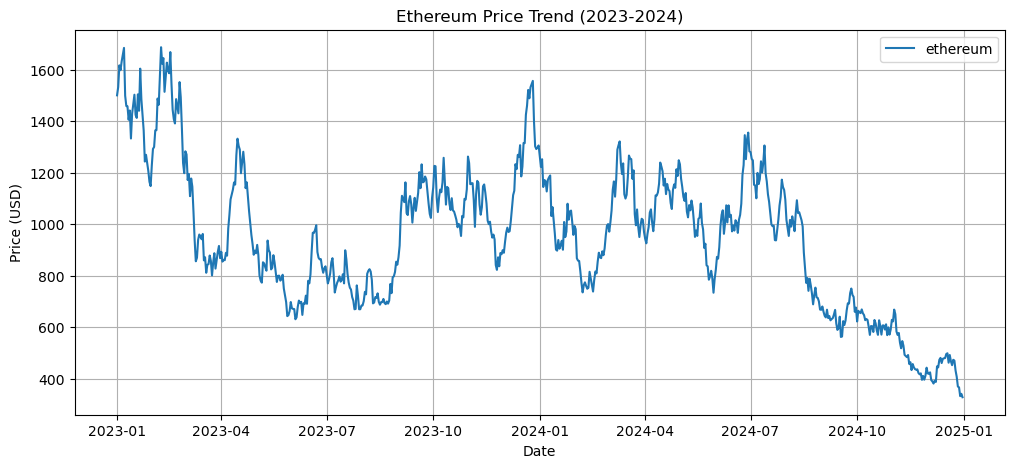

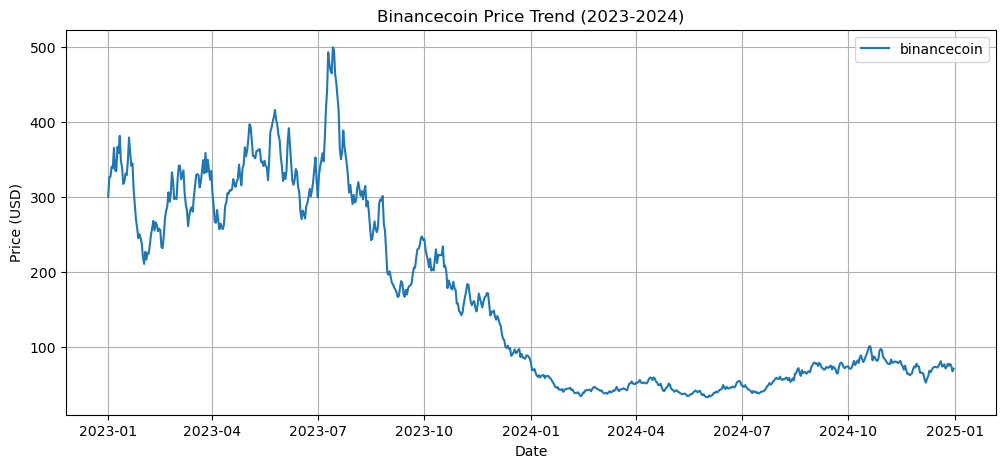

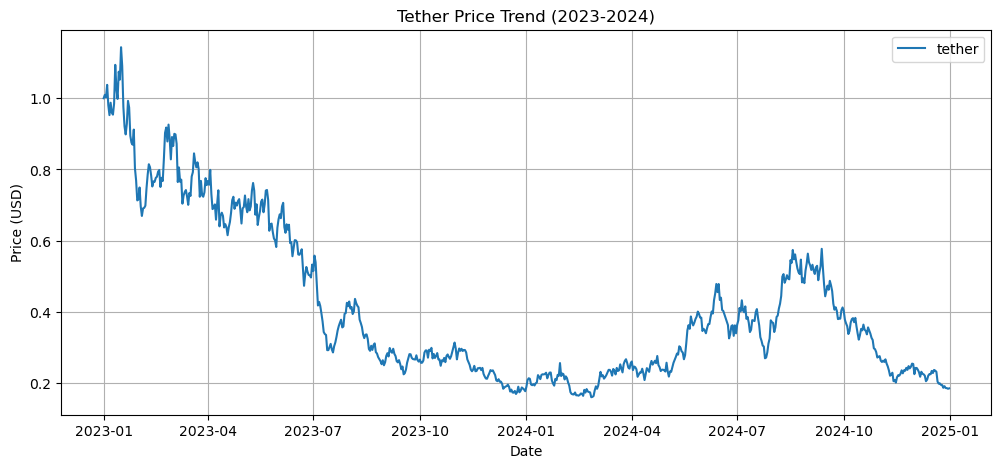

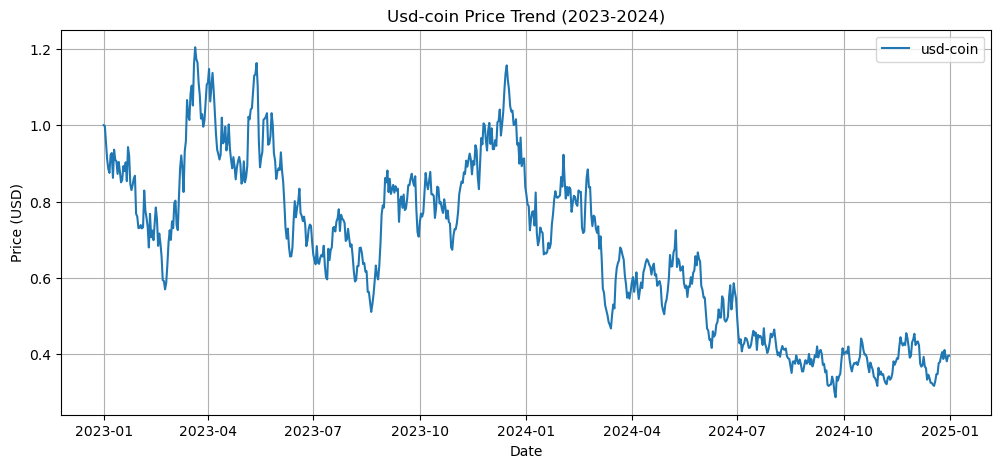

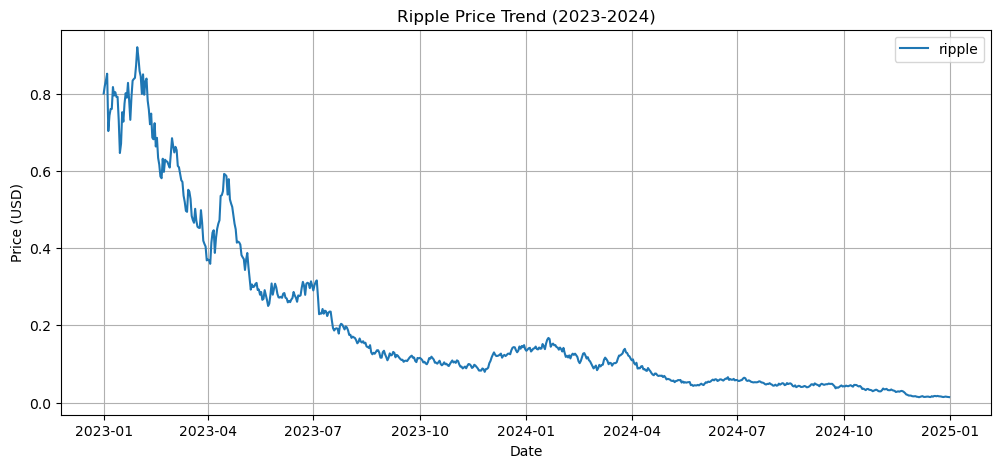

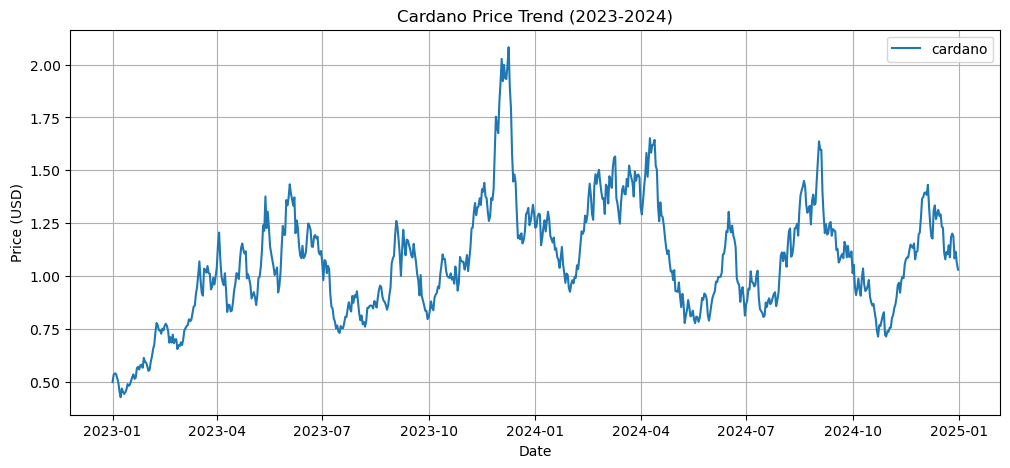

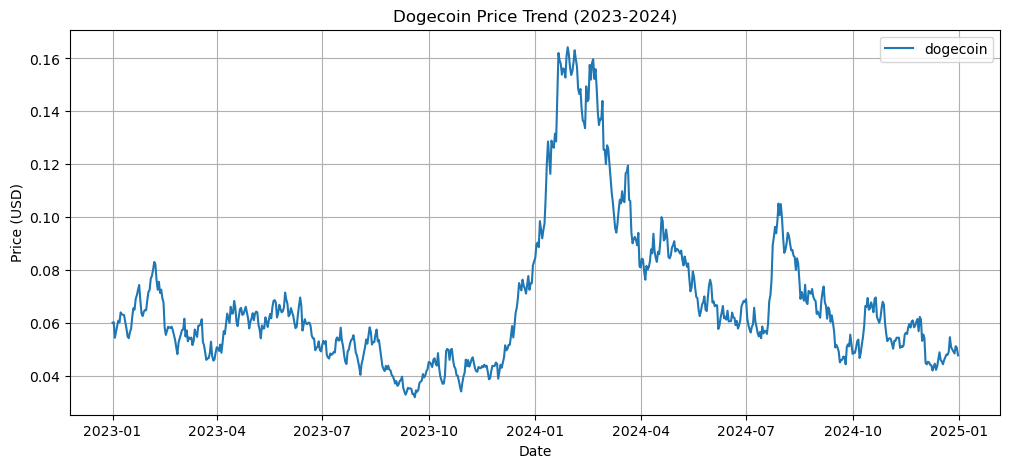

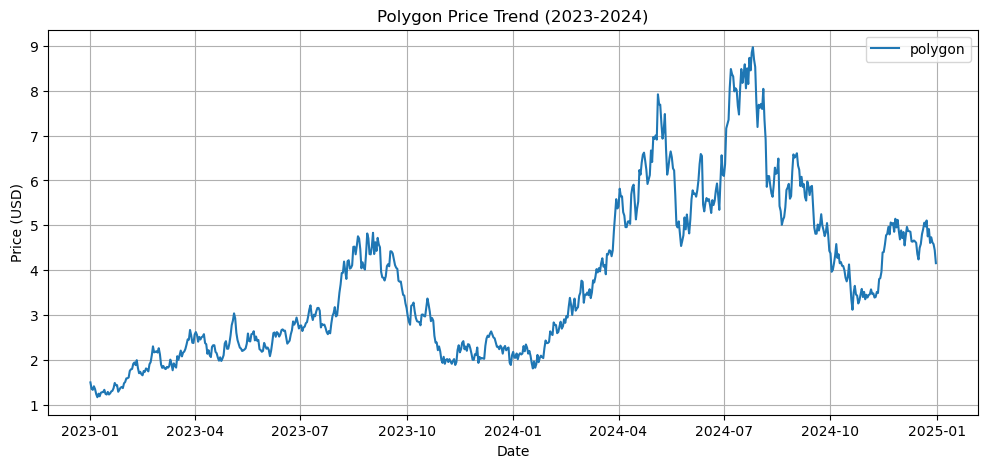

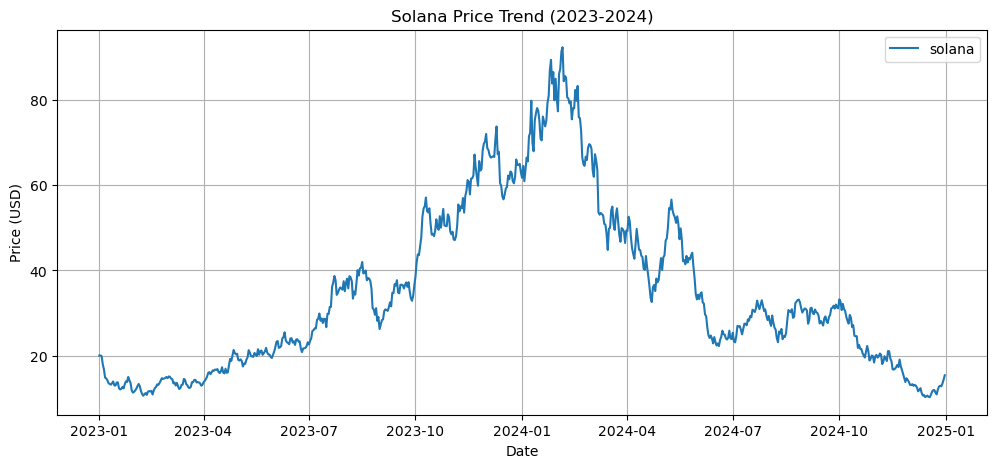

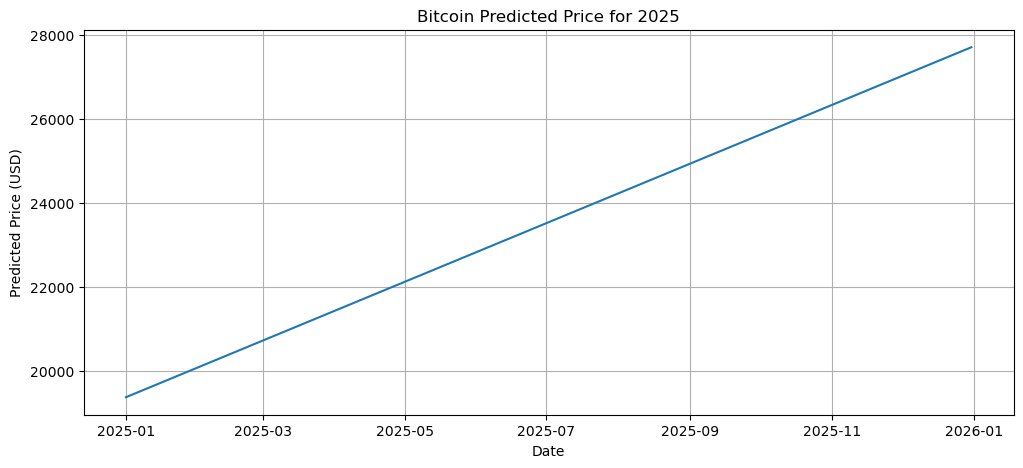

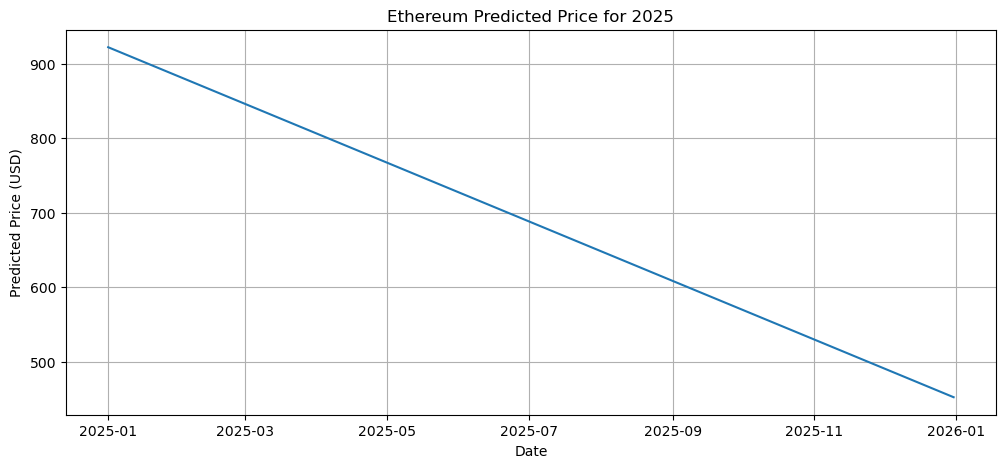

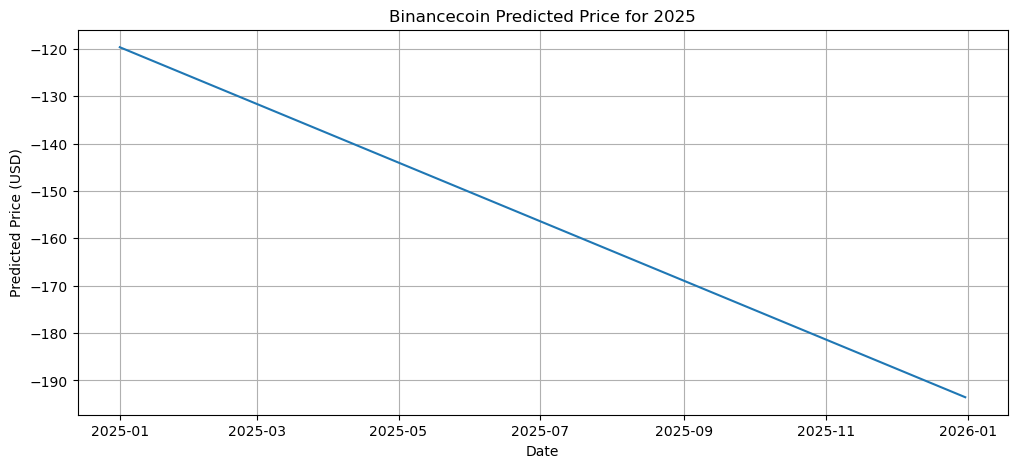

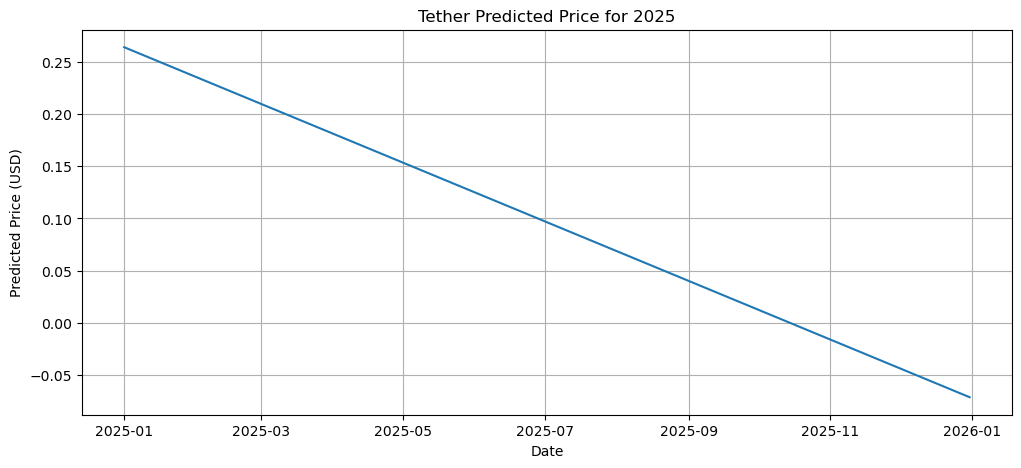

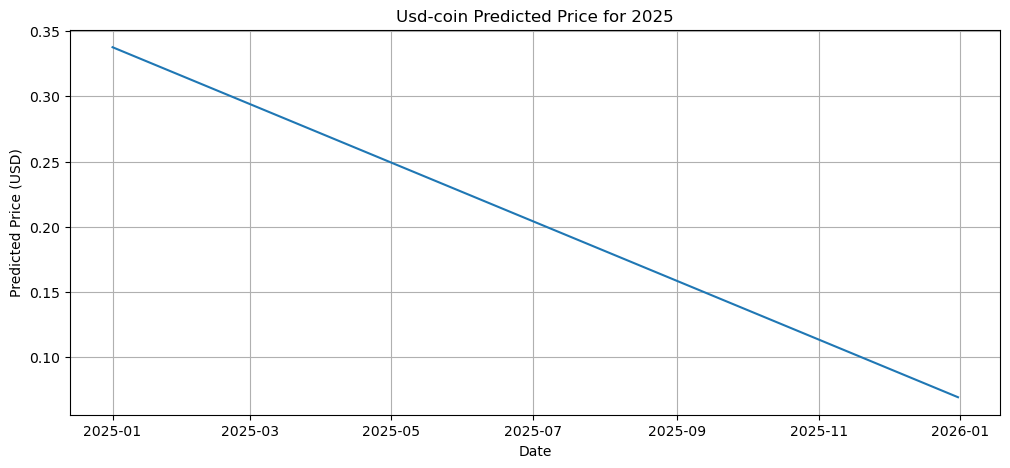

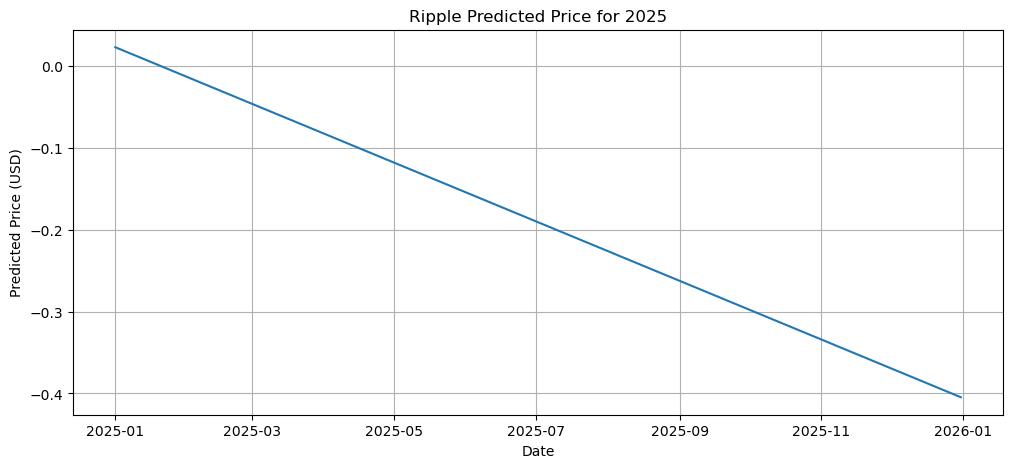

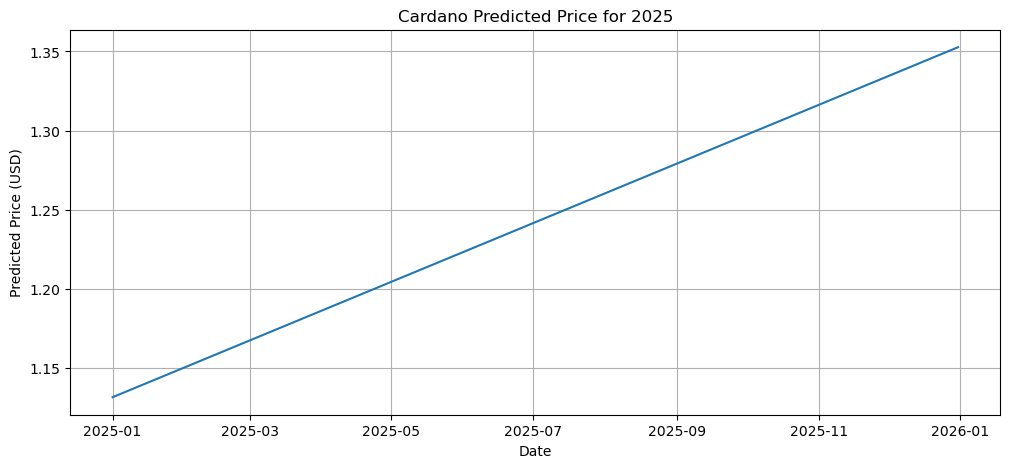

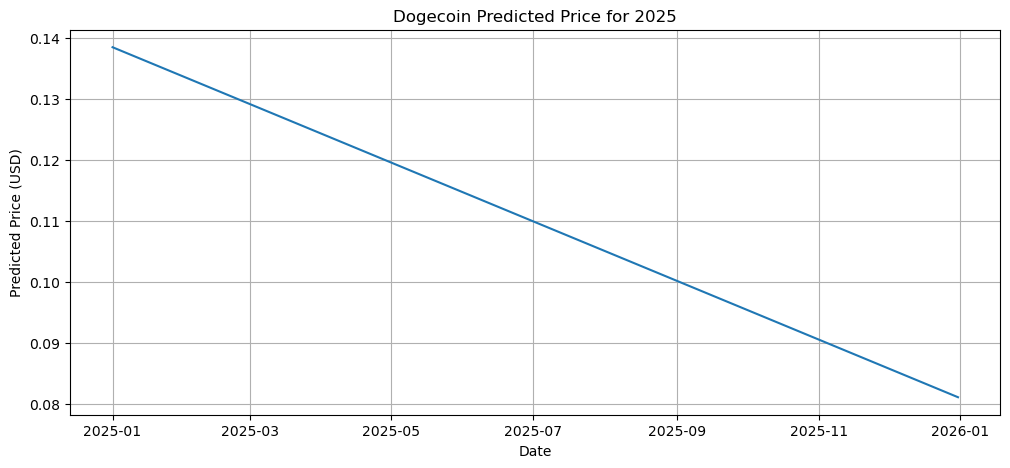

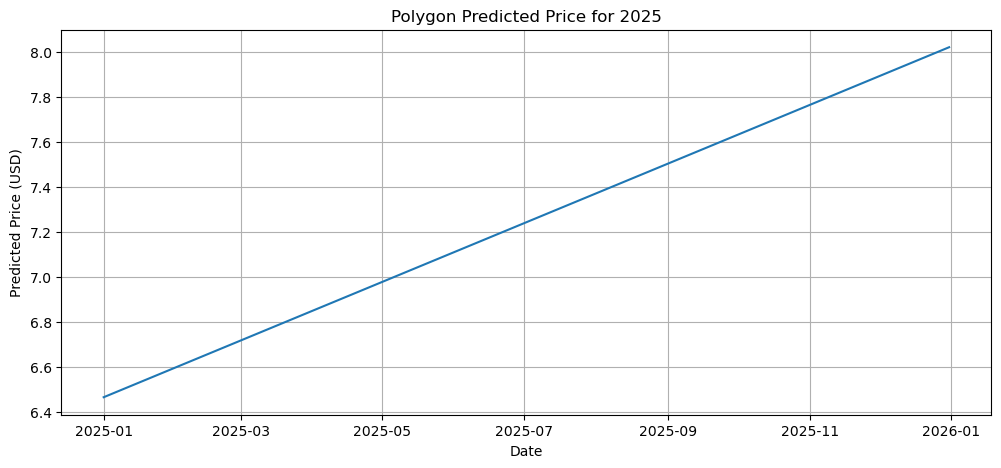

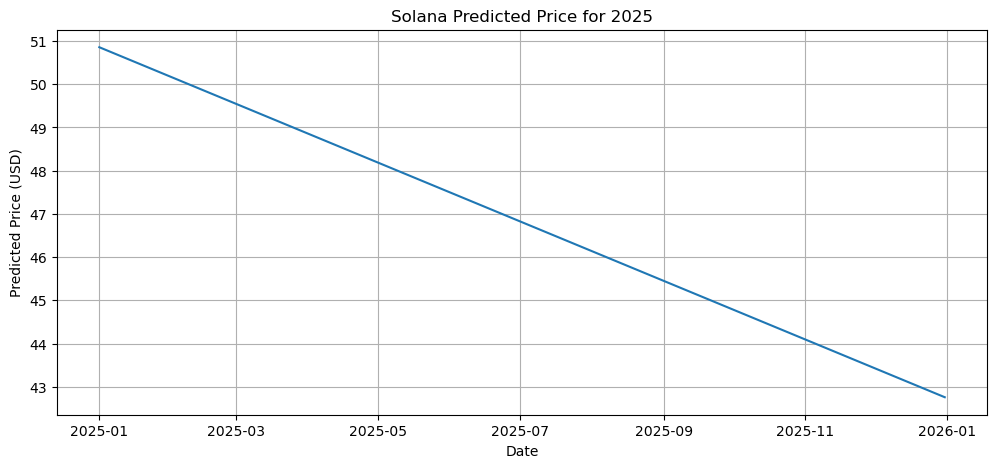

Bitcoin Model Performance:
RMSE: 6661.72, R2: 0.14

Ethereum Model Performance:
RMSE: 255.18, R2: 0.21

Binancecoin Model Performance:
RMSE: 65.57, R2: 0.71

Tether Model Performance:
RMSE: 0.16, R2: 0.49

Usd-coin Model Performance:
RMSE: 0.15, R2: 0.59

Ripple Model Performance:
RMSE: 0.11, R2: 0.74

Cardano Model Performance:
RMSE: 0.27, R2: 0.13

Dogecoin Model Performance:
RMSE: 0.02, R2: 0.42

Polygon Model Performance:
RMSE: 1.15, R2: 0.55

Solana Model Performance:
RMSE: 19.76, R2: -0.06



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import random
from datetime import datetime, timedelta

# Ensure VADER is available
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Function to simulate cryptocurrency price data
def simulate_crypto_data(name, start_price, noise=0.05):
    dates = pd.date_range(start='2023-01-01', end='2024-12-31')
    prices = [start_price]
    for _ in range(1, len(dates)):
        prices.append(prices[-1] * (1 + np.random.normal(0, noise)))
    df = pd.DataFrame({
        'date': dates,
        'crypto': name,
        'price': prices
    })
    return df

# Function to simulate news titles for sentiment analysis
def simulate_news_titles(df):
    example_news = [
        "Bitcoin hits new all-time high!",
        "Ethereum upgrade improves efficiency",
        "Market crash causes concern",
        "Investors bullish on crypto",
        "Regulation fears shake market"
    ]
    df['news_title'] = [random.choice(example_news) for _ in range(len(df))]
    df['sentiment'] = df['news_title'].apply(lambda x: sid.polarity_scores(x)['compound'])
    return df

# Fetch price data for top 10 cryptocurrencies
top_cryptos = [
    'bitcoin', 'ethereum', 'binancecoin', 'tether', 'usd-coin', 
    'ripple', 'cardano', 'dogecoin', 'polygon', 'solana'
]

price_data = pd.concat([simulate_crypto_data(crypto, start_price) for crypto, start_price in zip(top_cryptos, [20000, 1500, 300, 1, 1, 0.8, 0.5, 0.06, 1.5, 20])], ignore_index=True)
price_data = simulate_news_titles(price_data)

# Exploratory Data Analysis (EDA) - Plot separate price trends for each cryptocurrency
def plot_separated_price_trends(df):
    for crypto in df['crypto'].unique():
        plt.figure(figsize=(12, 5))
        crypto_df = df[df['crypto'] == crypto]
        sns.lineplot(x='date', y='price', data=crypto_df, label=crypto)
        plt.title(f"{crypto.capitalize()} Price Trend (2023-2024)")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.grid(True)
        plt.legend()
        plt.show()

plot_separated_price_trends(price_data)

# Feature Engineering - Add day, year, and sentiment features
def prepare_features_for_all(df):
    df = df.copy()
    df['day'] = df['date'].dt.dayofyear
    df['year'] = df['date'].dt.year
    df['sentiment'] = df['sentiment'].astype(float)
    return df[['crypto', 'day', 'year', 'sentiment']], df['price']

features_all, target_all = prepare_features_for_all(price_data)

# Train the model for each cryptocurrency and generate predictions for 2025
model_results = {}
for crypto in top_cryptos:
    crypto_data = features_all[features_all['crypto'] == crypto]
    crypto_target = target_all[features_all['crypto'] == crypto]
    
    X_train, X_test, y_train, y_test = train_test_split(crypto_data[['day', 'year', 'sentiment']], crypto_target, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    model_results[crypto] = {
        'model': model,
        'rmse': rmse,
        'r2': r2
    }
    
    # Plot prediction for each cryptocurrency
    future_dates = pd.date_range(start="2025-01-01", end="2025-12-31")
    future_df = pd.DataFrame({
        'date': future_dates,
        'day': future_dates.dayofyear,
        'year': [2025] * len(future_dates),
        'sentiment': [0.0] * len(future_dates)
    })
    future_predictions = model.predict(future_df[['day', 'year', 'sentiment']])
    future_df['predicted_price'] = future_predictions
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(x='date', y='predicted_price', data=future_df)
    plt.title(f"{crypto.capitalize()} Predicted Price for 2025")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price (USD)")
    plt.grid(True)
    plt.show()

# Displaying RMSE and R2 results for each cryptocurrency
for crypto, results in model_results.items():
    print(f"{crypto.capitalize()} Model Performance:")
    print(f"RMSE: {results['rmse']:.2f}, R2: {results['r2']:.2f}\n")


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import random
import time
from binance.client import Client
from datetime import datetime, timedelta

# Ensure VADER is available
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Binance API initialization (Replace with your own API keys)
api_key = 'your_binance_api_key'
api_secret = 'your_binance_api_secret'
client = Client(api_key, api_secret)

# Function to fetch cryptocurrency price data from Binance API
def fetch_binance_price_data(crypto_symbol='BTCUSDT', interval='1d', limit=730):
    try:
        # Fetch historical data from Binance
        klines = client.get_historical_klines(crypto_symbol, interval, limit=limit)
        
        # Convert to DataFrame
        df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        
        # Convert timestamp to datetime
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['price'] = df['close'].astype(float)
        df['crypto'] = crypto_symbol
        df = df[['date', 'price', 'crypto']]
        
        return df
    except Exception as e:
        print(f"Error fetching data for {crypto_symbol}: {e}")
        return pd.DataFrame()

# Fetch data for top 10 cryptocurrencies from Binance
top_cryptos = ['BTCUSDT', 'ETHUSDT', 'BNBUSD', 'XRPUSDT', 'ADAUSDT', 'DOGEUSDT', 'SOLUSDT', 'MATICUSDT', 'LTCUSDT', 'DOTUSDT']
price_data = pd.DataFrame()

for crypto in top_cryptos:
    crypto_data = fetch_binance_price_data(crypto)
    if not crypto_data.empty:
        price_data = pd.concat([price_data, crypto_data], ignore_index=True)

# Check if data was fetched successfully
if price_data.empty:
    print("No data fetched.")
else:
    print(f"Data successfully fetched for {len(price_data['crypto'].unique())} cryptocurrencies.")

# Simulate news titles for sentiment analysis (can be replaced with real news API later)
def simulate_news_titles(df):
    example_news = [
        "Bitcoin hits new all-time high!",
        "Ethereum upgrade improves efficiency",
        "Market crash causes concern",
        "Investors bullish on crypto",
        "Regulation fears shake market"
    ]
    df['news_title'] = [random.choice(example_news) for _ in range(len(df))]
    df['sentiment'] = df['news_title'].apply(lambda x: sid.polarity_scores(x)['compound'])
    return df

price_data = simulate_news_titles(price_data)

# Exploratory Data Analysis (EDA) - Plot separate price trends for each cryptocurrency
def plot_separated_price_trends(df):
    for crypto in df['crypto'].unique():
        plt.figure(figsize=(12, 5))
        crypto_df = df[df['crypto'] == crypto]
        sns.lineplot(x='date', y='price', data=crypto_df, label=crypto)
        plt.title(f"{crypto} Price Trend (2023-2024)")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.grid(True)
        plt.legend()
        plt.show()

plot_separated_price_trends(price_data)

# Feature Engineering - Add day, year, and sentiment features
def prepare_features_for_all(df):
    df = df.copy()
    df['day'] = df['date'].dt.dayofyear
    df['year'] = df['date'].dt.year
    df['sentiment'] = df['sentiment'].astype(float)
    return df[['crypto', 'day', 'year', 'sentiment']], df['price']

features_all, target_all = prepare_features_for_all(price_data)

# Train the model for each cryptocurrency and generate predictions for 2025
model_results = {}
for crypto in top_cryptos:
    crypto_data = features_all[features_all['crypto'] == crypto]
    crypto_target = target_all[features_all['crypto'] == crypto]
    
    X_train, X_test, y_train, y_test = train_test_split(crypto_data[['day', 'year', 'sentiment']], crypto_target, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    model_results[crypto] = {
        'model': model,
        'rmse': rmse,
        'r2': r2
    }
    
    # Plot prediction for each cryptocurrency
    future_dates = pd.date_range(start="2025-01-01", end="2025-12-31")
    future_df = pd.DataFrame({
        'date': future_dates,
        'day': future_dates.dayofyear,
        'year': [2025] * len(future_dates),
        'sentiment': [0.0] * len(future_dates)
    })
    future_predictions = model.predict(future_df[['day', 'year', 'sentiment']])
    future_df['predicted_price'] = future_predictions
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(x='date', y='predicted_price', data=future_df)
    plt.title(f"{crypto} Predicted Price for 2025")
    plt.xlabel("Date")
    plt.ylabel("Predicted Price (USD)")
    plt.grid(True)
    plt.show()

# Displaying RMSE and R2 results for each cryptocurrency
for crypto, results in model_results.items():
    print(f"{crypto} Model Performance:")
    print(f"RMSE: {results['rmse']:.2f}, R2: {results['r2']:.2f}\n")


ModuleNotFoundError: No module named 'binance'